**IMPORT LIBRARIES**

In [2]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob


**Dataset paths**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
train_path = r'/content/drive/MyDrive/Leaves Pathogen/Training Set'
valid_path = r'/content/drive/MyDrive/Leaves Pathogen/Validation Set'

image_files - Paths of Training images

valid_image_files - Paths of validation images

folders - Labels

In [28]:
image_files = glob(train_path + '/*/*.JPG')
valid_image_files = glob(valid_path + '/*/*.JPG')
folders = glob(train_path + '/*')

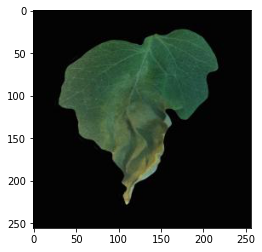

In [7]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [ ]:
IMAGE_SIZE = [224, 224] 
epochs = 20
batch_size = 8

**VGG MODEL used as Backbone**

In [8]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


**In order to not train the VGG Model**

In [9]:
for layer in vgg.layers:
  layer.trainable = False

** Extra Layers**

In [10]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

**Model Object**

In [11]:
model = Model(inputs=vgg.input, outputs=prediction)

In [12]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [13]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

**IMAGE GENERATOR**

In [14]:
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

**LABELS**

In [45]:
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)

for k, v in test_gen.class_indices.items():
  labels[v] = k

print(labels)


Found 60 images belonging to 6 classes.
{'Bacterial_Spot': 0, 'Early_Blight': 1, 'Healthy': 2, 'Late_Blight': 3, 'Leaf_Mold': 4, 'Mosaic_Virus': 5}
['Bacterial_Spot', 'Early_Blight', 'Healthy', 'Late_Blight', 'Leaf_Mold', 'Mosaic_Virus']


**CREATE GENERATORS**

In [ ]:
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

**FIT THE MODEL**

In [32]:
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // 8,
  verbose = 1,
)

Found 180 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Epoch 1/20
22/22 [==============================] - 115s 5s/step - loss: 21.2781 - accuracy: 0.3779 - val_loss: 17.6576 - val_accuracy: 0.3750
Epoch 2/20
22/22 [==============================] - 112s 5s/step - loss: 9.6800 - accuracy: 0.5756 - val_loss: 10.2806 - val_accuracy: 0.6071
Epoch 3/20
22/22 [==============================] - 112s 5s/step - loss: 6.8476 - accuracy: 0.6686 - val_loss: 12.2619 - val_accuracy: 0.5536
Epoch 4/20
22/22 [==============================] - 112s 5s/step - loss: 5.6165 - accuracy: 0.7326 - val_loss: 11.2258 - val_accuracy: 0.5536
Epoch 5/20
22/22 [==============================] - 112s 5s/step - loss: 5.7397 - accuracy: 0.7209 - val_loss: 8.5990 - val_accuracy: 0.6964
Epoch 6/20
22/22 [==============================] - 112s 5s/step - loss: 4.0649 - accuracy: 0.7558 - val_loss: 6.6062 - val_accuracy: 0.6964
Epoch 7/20
22/22 [==============================] - 111s 5s/step - l

** ACCRACY AND LOSS PLOTS**

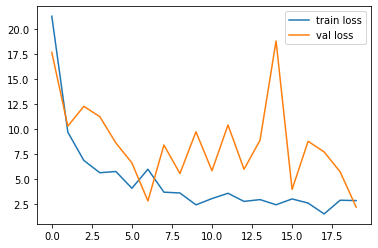

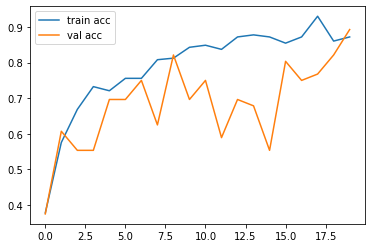

In [33]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

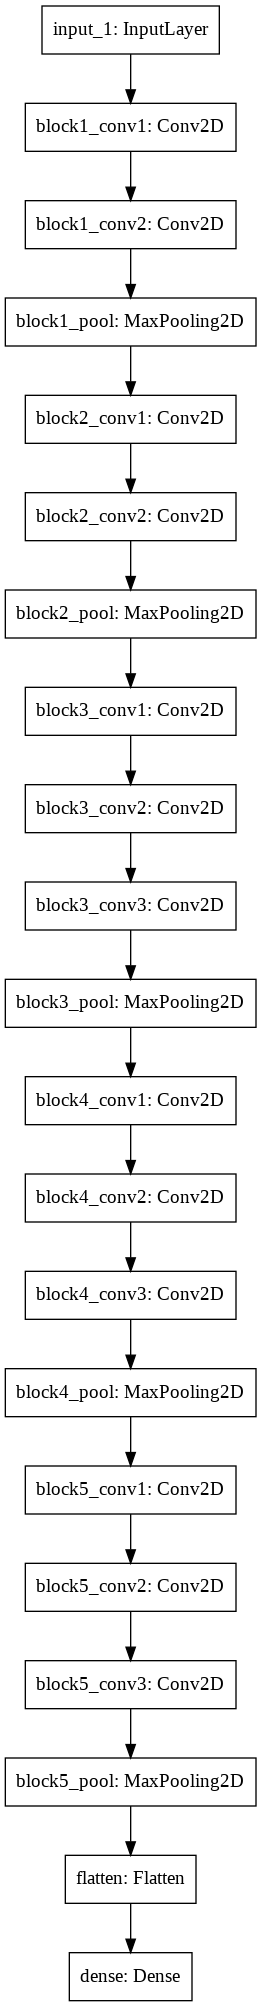

In [37]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

**CONFUSION MATRIX**

In [34]:
def get_confusion_matrix(data_path, N):
  
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm


In [35]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 178
Found 180 images belonging to 6 classes.
[[27  2  1  0  0  0]
 [ 0 27  1  1  0  1]
 [ 0  0 29  0  0  1]
 [ 0  1  1 27  0  1]
 [ 0  0  0  1 25  4]
 [ 0  0  0  0  0 30]]
Generating confusion matrix 60
Found 60 images belonging to 6 classes.
[[ 7  3  0  0  0  0]
 [ 4  6  0  0  0  0]
 [ 0  0 10  0  0  0]
 [ 0  0  1  9  0  0]
 [ 0  1  0  1  8  0]
 [ 0  0  0  0  1  9]]
